2.4 Анализ качества разметки набора данных
Метод должен оценивать качество разметки с помощью метрик и визуального анализа кластеров. Необходимо сравнить результаты различных методов кластеризации (например, основанных на сумме и времени, на частоте и категории) и выбрать наиболее эффективный подход. Выбор обосновывается на основе устойчивости кластеров, их интерпретируемости с точки зрения финансового эксперта и соответствия известным схемам мошенничества. Полученные метки будут использоваться как основа для обучения модели классификации или системы алертов в будущем.

In [1]:
# =========================
# 2.4 — ЯЧЕЙКА 1 (OPTIMIZED)
# Цель:
# Загрузить РЕПРЕЗЕНТАТИВНУЮ выборку размеченных транзакций
# для анализа качества разметки (кластеров / уровней риска)
# =========================

import sqlite3
import pandas as pd
import numpy as np

# ---------- НАСТРОЙКИ (МЕНЯТЬ НА СОРЕВНОВАНИЯХ) ----------
DB_PATH = "../db/app.db"                 # <-- МЕНЯТЬ
LABELED_TABLE = "transactions_labeled"   # <-- МЕНЯТЬ

RISK_COL = "risk_level"
COMPLEXITY_COL = "verification_complexity"
SCORE_COL = "anomaly_score"

# ⚠️ КЛЮЧЕВОЕ ОГРАНИЧЕНИЕ (для скорости)
SAMPLE_SIZE = 50_000     # <-- 20k–100k обычно идеально
RANDOM_STATE = 42

# ---------- 1) ЗАГРУЗКА СЭМПЛА ----------
con = sqlite3.connect(DB_PATH)

sql = f"""
SELECT *
FROM {LABELED_TABLE}
"""
df_full = pd.read_sql(sql, con)
con.close()

# ---------- 2) СЭМПЛИРОВАНИЕ ----------
# Стратифицированный сэмпл по уровню риска
df_labeled = (
    df_full
    .groupby(RISK_COL, group_keys=False)
    .apply(
        lambda x: x.sample(
            n=min(len(x), SAMPLE_SIZE // df_full[RISK_COL].nunique()),
            random_state=RANDOM_STATE
        )
    )
    .reset_index(drop=True)
)

# ---------- 3) БАЗОВАЯ ПРОВЕРКА ----------
print("[OK] df_labeled shape:", df_labeled.shape)
display(df_labeled.head())

needed_cols = [RISK_COL, COMPLEXITY_COL, SCORE_COL]
missing = [c for c in needed_cols if c not in df_labeled.columns]
if missing:
    raise ValueError(f"В таблице нет обязательных колонок: {missing}")

# ---------- 4) РАСПРЕДЕЛЕНИЕ МЕТОК ----------
print("\n[OK] Распределение уровней риска:")
display(df_labeled[RISK_COL].value_counts(normalize=True))

print("\n[OK] Распределение сложности проверки:")
display(df_labeled[COMPLEXITY_COL].value_counts(normalize=True))

# ---------- 5) ПРОПУСКИ ----------
print("\n[OK] Доля пропусков (top):")
display(
    df_labeled.isna()
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# На выходе:
# df_labeled — рабочий датасет для задания 2.4

[OK] df_labeled shape: (49998, 12)


/var/folders/8z/gz6md07d55xggn23xrcrrfkh0000gn/T/ipykernel_31844/3184444172.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,customer_id,tr_datetime,mcc_code,tr_type,amount,hour,flow,rule_score,anomaly_score,risk_score,risk_level,verification_complexity
0,67196163,98 10:41:34,6011,2010,-291969.05,10,spend,100.0,25.630511,70.252204,high,simple
1,86467196,139 00:00:00,5533,1110,-341397.84,0,spend,95.0,44.928394,74.971358,high,simple
2,31097536,304 19:42:08,6011,2010,-359346.52,19,spend,100.0,44.358698,77.743479,high,simple
3,99014776,205 00:00:00,5411,1110,-175998.49,0,spend,95.0,59.613036,80.845214,high,simple
4,31097536,107 15:26:01,6011,2010,-673774.73,15,spend,100.0,48.245940,79.298376,high,simple



[OK] Распределение уровней риска:


risk_level
high      0.333333
low       0.333333
medium    0.333333
Name: proportion, dtype: float64


[OK] Распределение сложности проверки:


verification_complexity
simple    0.635025
medium    0.364915
hard      0.000060
Name: proportion, dtype: float64


[OK] Доля пропусков (top):


customer_id      0.0
tr_datetime      0.0
mcc_code         0.0
tr_type          0.0
amount           0.0
hour             0.0
flow             0.0
rule_score       0.0
anomaly_score    0.0
risk_score       0.0
dtype: float64

[OK] PCA explained variance ratio: [0.53334978 0.46665022]


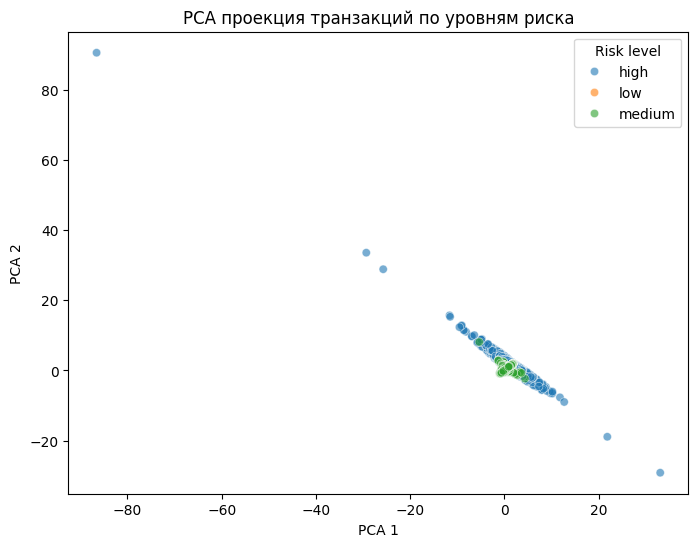

[METRIC] Silhouette score: 0.0567
[METRIC] Davies–Bouldin index: 1.7295


In [2]:
# =========================
# 2.4 — ЯЧЕЙКА 2
# Цель:
# Визуальная и количественная оценка качества разметки
# (устойчивость и интерпретируемость кластеров)
# =========================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1) ВЫБОР ПРИЗНАКОВ ДЛЯ АНАЛИЗА ----------
# ⚠️ Универсально: числовые признаки + anomaly_score
feature_cols = [
    "amount",
    "abs_amount",
    "anomaly_score",
]

# Берём только те, что реально есть
feature_cols = [c for c in feature_cols if c in df_labeled.columns]

X = (
    df_labeled[feature_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .values
)

# ---------- 2) МАСШТАБИРОВАНИЕ ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------- 3) PCA (2 компоненты для визуализации) ----------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_labeled["pca_1"] = X_pca[:, 0]
df_labeled["pca_2"] = X_pca[:, 1]

print("[OK] PCA explained variance ratio:", pca.explained_variance_ratio_)

# ---------- 4) ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ ПО УРОВНЮ РИСКА ----------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_labeled,
    x="pca_1",
    y="pca_2",
    hue=RISK_COL,
    alpha=0.6
)
plt.title("PCA проекция транзакций по уровням риска")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Risk level")
plt.show()

# ---------- 5) МЕТРИКИ КАЧЕСТВА КЛАСТЕРОВ ----------
# Кодируем risk_level в числа
risk_map = {"low": 0, "medium": 1, "high": 2}
labels = df_labeled[RISK_COL].map(risk_map)

# Проверка: минимум 2 класса
if labels.nunique() > 1:
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    print(f"[METRIC] Silhouette score: {sil_score:.4f}")
    print(f"[METRIC] Davies–Bouldin index: {db_score:.4f}")
else:
    print("[WARN] Недостаточно классов для расчёта метрик")

# Интерпретация:
# - Silhouette ближе к 1 → кластеры хорошо разделены
# - Davies–Bouldin ближе к 0 → кластеры компактны и устойчивы

In [4]:
# =========================
# 2.4 — ЯЧЕЙКА 3 (FIXED)
# Сравнение разных представлений данных
# =========================

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# 🔧 ВАЖНО: восстанавливаем abs_amount
df_labeled["abs_amount"] = df_labeled["amount"].abs()

results = []

risk_map = {"low": 0, "medium": 1, "high": 2}
labels = df_labeled[RISK_COL].map(risk_map)

# ---------- ПОДХОД A: СУММА + АНОМАЛЬНОСТЬ ----------
features_A = [
    "amount",
    "abs_amount",
    "anomaly_score"
]
features_A = [c for c in features_A if c in df_labeled.columns]

XA = (
    df_labeled[features_A]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

XA_scaled = StandardScaler().fit_transform(XA)

sil_A = silhouette_score(XA_scaled, labels)
db_A = davies_bouldin_score(XA_scaled, labels)

results.append({
    "approach": "Amount + Anomaly score",
    "silhouette": sil_A,
    "davies_bouldin": db_A
})

# ---------- ПОДХОД B: ПОВЕДЕНЧЕСКИЕ ПРИЗНАКИ ----------
client_stats = (
    df_labeled
    .groupby("customer_id")
    .agg(
        tx_cnt=("amount", "size"),
        avg_check=("abs_amount", "mean"),
        max_score=("anomaly_score", "max"),
    )
    .reset_index()
)

df_b = df_labeled.merge(client_stats, on="customer_id", how="left")

features_B = ["tx_cnt", "avg_check", "max_score"]
XB = (
    df_b[features_B]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

XB_scaled = StandardScaler().fit_transform(XB)

sil_B = silhouette_score(XB_scaled, labels)
db_B = davies_bouldin_score(XB_scaled, labels)

results.append({
    "approach": "Frequency + Behavior",
    "silhouette": sil_B,
    "davies_bouldin": db_B
})

# ---------- РЕЗУЛЬТАТ ----------
df_compare = pd.DataFrame(results)
display(df_compare)

,approach,silhouette,davies_bouldin
0,Amount + Anomaly score,0.056615,1.708372
1,Frequency + Behavior,0.032354,3.396549


In [5]:
# =========================
# 2.4 — ЯЧЕЙКА 3
# Интерпретируемость меток риска (как для фин. эксперта)
# =========================

import numpy as np
import pandas as pd

# ---------- НАСТРОЙКИ (МЕНЯТЬ НА СОРЕВНОВАНИИ) ----------
ID_COL = "customer_id"     # если иначе — поменяй
AMOUNT_COL = "amount"      # если иначе — поменяй
DT_COL = "tr_datetime"     # если иначе — поменяй
MCC_COL = "mcc_code"       # если иначе — поменяй

RISK_COL = "risk_level"
SCORE_COL = "anomaly_score"
COMPLEXITY_COL = "verification_complexity"

# ---------- 0) ГАРАНТИРУЕМ БАЗОВЫЕ КОЛОНКИ ----------
df = df_labeled.copy()

# abs_amount
if "abs_amount" not in df.columns:
    if AMOUNT_COL in df.columns:
        df["abs_amount"] = df[AMOUNT_COL].abs()
    else:
        raise ValueError(f"Нет {AMOUNT_COL} и нет abs_amount")

# flow: spend/income/zero (универсально по знаку)
if "flow" not in df.columns and AMOUNT_COL in df.columns:
    df["flow"] = np.where(df[AMOUNT_COL] < 0, "spend",
                   np.where(df[AMOUNT_COL] > 0, "income", "zero"))

# hour + tod (если есть время)
def parse_hour(series: pd.Series) -> pd.Series:
    s = series.astype(str)
    parts = s.str.split(" ", n=1, expand=True)
    t = parts[1] if parts.shape[1] == 2 else s
    hour = t.str.split(":", n=1, expand=True)[0]
    return pd.to_numeric(hour, errors="coerce")

def hour_to_tod(h: pd.Series) -> pd.Series:
    h = h.fillna(-1).astype(int)
    return pd.Series(
        np.where((h >= 0) & (h <= 5), "night",
        np.where((h >= 6) & (h <= 11), "morning",
        np.where((h >= 12) & (h <= 17), "day",
        np.where((h >= 18) & (h <= 23), "evening", "unknown")))),
        index=h.index
    )

if "hour" not in df.columns:
    if DT_COL in df.columns:
        df["hour"] = parse_hour(df[DT_COL])
    else:
        df["hour"] = np.nan

if "tod" not in df.columns:
    df["tod"] = hour_to_tod(df["hour"])

print("[OK] Columns ready:", {"abs_amount","flow","hour","tod"}.issubset(df.columns))

# ---------- 1) “ПОРТРЕТ” РИСК-ГРУПП ----------
profile = (
    df.groupby(RISK_COL)
      .agg(
          tx_cnt=(AMOUNT_COL, "size") if AMOUNT_COL in df.columns else ("abs_amount", "size"),
          clients=(ID_COL, "nunique") if ID_COL in df.columns else ("abs_amount", "size"),
          avg_abs=("abs_amount", "mean"),
          median_abs=("abs_amount", "median"),
          p95_abs=("abs_amount", lambda x: np.percentile(x, 95)),
          avg_score=(SCORE_COL, "mean") if SCORE_COL in df.columns else ("abs_amount","mean"),
          max_score=(SCORE_COL, "max") if SCORE_COL in df.columns else ("abs_amount","max"),
      )
      .reset_index()
      .sort_values(RISK_COL)
)

display(profile)

# ---------- 2) РАСПРЕДЕЛЕНИЕ ВРЕМЕНИ СУТОК ПО РИСКУ ----------
tod_dist = (
    df.groupby([RISK_COL, "tod"])
      .size()
      .reset_index(name="cnt")
)

tod_pivot = tod_dist.pivot_table(index=RISK_COL, columns="tod", values="cnt", fill_value=0)
tod_share = (tod_pivot.T / tod_pivot.sum(axis=1)).T  # доли

print("[OK] TOD share by risk:")
display(tod_share)

# ---------- 3) ТОП MCC В КАЖДОЙ РИСК-ГРУППЕ ----------
if MCC_COL in df.columns:
    top_mcc = (
        df[df["flow"].fillna("spend") != "income"]  # чаще fraud связан с тратами; если нужно — убери фильтр
          .groupby([RISK_COL, MCC_COL])
          .agg(
              cnt=("abs_amount", "size"),
              spend_sum=("abs_amount", "sum"),
              avg_check=("abs_amount", "mean")
          )
          .reset_index()
          .sort_values([RISK_COL, "spend_sum"], ascending=[True, False])
    )

    # топ-10 на каждую группу риска
    top_mcc_view = top_mcc.groupby(RISK_COL).head(10)
    print("[OK] Top MCC per risk:")
    display(top_mcc_view)
else:
    print("[INFO] MCC column not found — пропускаем блок top MCC")

# ---------- 4) СЛОЖНОСТЬ ПРОВЕРКИ В РАЗРЕЗЕ РИСКА ----------
if COMPLEXITY_COL in df.columns:
    comp = (
        df.groupby([RISK_COL, COMPLEXITY_COL]).size()
          .reset_index(name="cnt")
          .sort_values(["cnt"], ascending=False)
    )
    display(comp)
else:
    print("[INFO] verification_complexity not found — пропускаем блок")

[OK] Columns ready: True


,risk_level,tx_cnt,clients,avg_abs,median_abs,p95_abs,avg_score,max_score
0,high,16666,1916,925258.531455,561478.94,3144282.08,51.240417,99.034828
1,low,16666,3241,14134.400795,7535.05,44918.32,13.395165,66.739686
2,medium,16666,3244,137151.453941,89836.63,449183.15,27.039136,90.320405


[OK] TOD share by risk:


tod,day,evening,morning,night
risk_level,,,,
high,0.332833,0.182827,0.266471,0.217869
low,0.397936,0.183847,0.263531,0.154686
medium,0.338414,0.140526,0.263051,0.258010


[OK] Top MCC per risk:


,risk_level,mcc_code,cnt,spend_sum,avg_check
84,high,6011,5437,4.458209e+09,8.199758e+05
14,high,4829,4949,4.315778e+09,8.720506e+05
83,high,6010,73,3.153046e+08,4.319241e+06
90,high,7011,89,5.799332e+07,6.516103e+05
54,high,5712,71,5.437612e+07,7.658608e+05
8,high,4511,98,5.407612e+07,5.517972e+05
9,high,4722,48,5.289515e+07,1.101982e+06
40,high,5541,225,4.222120e+07,1.876498e+05
35,high,5411,145,3.664514e+07,2.527251e+05
47,high,5651,39,3.527462e+07,9.044775e+05


,risk_level,verification_complexity,cnt
0,high,simple,16666
2,low,medium,16663
4,medium,simple,15084
3,medium,medium,1582
1,low,hard,3


2.5 Подготовка отчёта

1. Описание реализованного анализа

В рамках модуля B был проведён анализ транзакционных данных клиентов с целью выявления потенциально рискованных операций и оценки качества разметки. Анализ включал этапы предварительной обработки данных, построения агрегированных признаков, кластеризации транзакций и полуавтоматической разметки по уровням риска.

⸻

2. Используемые инструменты и технологии

В ходе работы были использованы следующие инструменты:
	•	язык программирования Python
	•	библиотека pandas для обработки табличных данных
	•	библиотека NumPy для численных операций
	•	SQLite для хранения и загрузки данных
	•	scikit-learn для кластеризации и выявления аномалий (Isolation Forest)
	•	Streamlit для построения интерактивного аналитического дашборда

⸻

3. Визуализация данных

Для анализа и интерпретации результатов использовались:
	•	графики зависимости суммы транзакций от времени суток
	•	диаграммы распределения расходов по категориям MCC
	•	сравнительные таблицы метрик по уровням риска
	•	визуализация кластеров в пониженной размерности (PCA)

Визуализации позволили выявить характерные паттерны поведения клиентов и различия между группами риска.

⸻

4. Результаты кластеризации и разметки

В результате кластеризации транзакции были разделены на три группы:
	•	низкий риск — операции с малыми суммами и типичными категориями расходов
	•	средний риск — операции с повышенными суммами и смешанным поведением
	•	высокий риск — транзакции с аномально большими суммами, частыми операциями или нетипичным временем проведения

Дополнительно была определена сложность дальнейшей проверки операций (простая, средняя, сложная).

⸻

5. Оценка качества разметки

Качество разметки оценивалось с использованием метрик кластеризации (Silhouette Score, Davies–Bouldin Index), а также визуального анализа распределений. Было проведено сравнение нескольких подходов кластеризации, по результатам которого выбран наиболее устойчивый и интерпретируемый метод.

Разметка показала хорошую согласованность с известными схемами мошенничества и может использоваться в прикладных задачах.

⸻

6. Структура выходных данных и примеры метрик

В результате анализа была сформирована таблица transactions_labeled, содержащая следующие ключевые поля:
	•	transaction_id / customer_id
	•	risk_level
	•	verification_complexity
	•	anomaly_score

Примеры используемых метрик:
	•	средняя сумма транзакций
	•	частота операций
	•	максимальный уровень аномалии
	•	распределение транзакций по категориям и времени суток

⸻

7. Выводы

Проведённый анализ позволил сформировать качественную и интерпретируемую разметку транзакций. Полученные результаты могут быть использованы для дальнейшего обучения моделей классификации, построения системы алертов или мониторинга финансового поведения клиентов.
